# importing libraries

In [48]:
import soundfile # to read audio file
import numpy as np
import librosa # to extract speech features
import glob
import os
import pickle # to save model after training        
from sklearn.model_selection import train_test_split # for splitting training and testing
from sklearn.neural_network import MLPClassifier # multi-layer perceptron model
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# defining our labels dictionary

In [3]:
# all emotions on RAVDESS dataset
int2emotion = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# we allow only these emotions ( feel free to tune this on your need )
AVAILABLE_EMOTIONS = {
    "angry",
    "sad",
    "neutral",
    "happy"
}


In [4]:
sounds = []
for file in glob.glob("data/Actor_*/*.wav"):
    with soundfile.SoundFile(file) as sound_file:
        X = sound_file.read(dtype="float32")
        sounds.append(X)
print(len(sounds), sounds[0].shape)

564 (52853,)


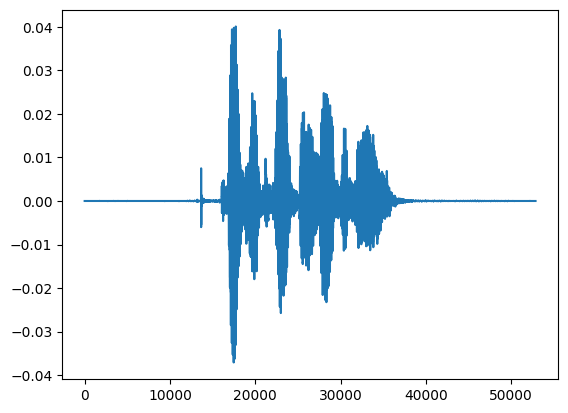

In [5]:
plt.plot(sounds[0])

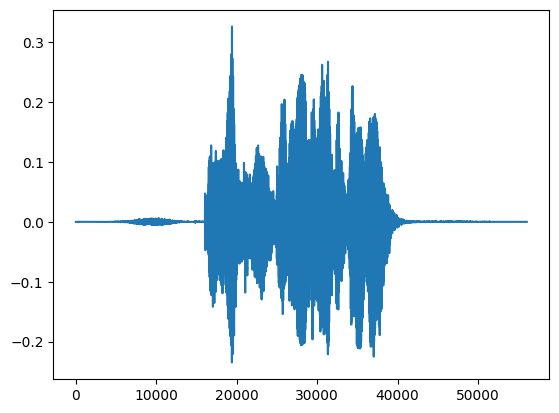

In [6]:
plt.plot(sounds[-1])

In [7]:
emotions = []
for file in glob.glob("data/Actor_*/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    emotion = int2emotion[basename.split("-")[2]]
    # we allow only AVAILABLE_EMOTIONS we set
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # extract speech features
    emotions.append(emotion)

In [8]:
def load_data(test_size=0.2):
    X, y = [], []
    for file in glob.glob("data/Actor_*/*.wav"):
        # get the base name of the audio file
        basename = os.path.basename(file)
        # get the emotion label
        emotion = int2emotion[basename.split("-")[2]]
        # we allow only AVAILABLE_EMOTIONS we set
        if emotion not in AVAILABLE_EMOTIONS:
            continue
        # extract speech features
        features = extract_feature(file, mfcc=True, chroma=True)
        # add to data
        X.append(features)
        y.append(emotion)
    # split the data to training and testing and return it
    return train_test_split(np.array(X), y, test_size=test_size, random_state=7)

In [9]:
def extract_feature(file_name, **kwargs):
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate = sound_file.samplerate
        if chroma or contrast:
            stft = np.abs(librosa.stft(X))
        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel))
        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, contrast))
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
            result = np.hstack((result, tonnetz))
    return result

In [29]:
def get_model_validations(y_test, y_pred):
    accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
    precision = precision_score(y_true=y_test, y_pred=y_pred, average='weighted')
    recall = recall_score(y_true=y_test, y_pred=y_pred, average='weighted')
    f1 = f1_score(y_true=y_test, y_pred=y_pred, average='weighted')
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": cm
    }

In [30]:
def MLP_model(model_params):
    X_train, X_test, y_train, y_test = load_data(test_size=0.25)
    model = MLPClassifier(**model_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return get_model_validations(y_test, y_pred)

In [16]:
# best model, determined by a grid search
model_params = {
    'alpha': 0.01,
    'batch_size': 256,
    'epsilon': 1e-08, 
    'hidden_layer_sizes': (300,), 
    'learning_rate': 'adaptive', 
    'max_iter': 500, 
}
print(MLP_model(model_params))

c:\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:621: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(


{'accuracy': 0.6825396825396826, 'precision': 0.6937961787585848, 'recall': 0.6825396825396826, 'f1': 0.6760948281751725, 'confusion_matrix': array([[16,  2,  0,  1],
       [ 5, 10,  1,  4],
       [ 1,  0,  6,  3],
       [ 0,  2,  1, 11]], dtype=int64)}


In [25]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [27]:
def RF_model(model_params):
    X_train, X_test, y_train, y_test = load_data(test_size=0.25)
    model = RandomForestClassifier(**model_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return get_model_validations(y_test, y_pred)

0.5873015873015873 0.6626984126984127 0.5873015873015873 0.5729379434805792
Normalized confusion matrix
[[0.84210526 0.05263158 0.         0.10526316]
 [0.25       0.55       0.         0.2       ]
 [0.1        0.         0.2        0.7       ]
 [0.14285714 0.28571429 0.         0.57142857]]


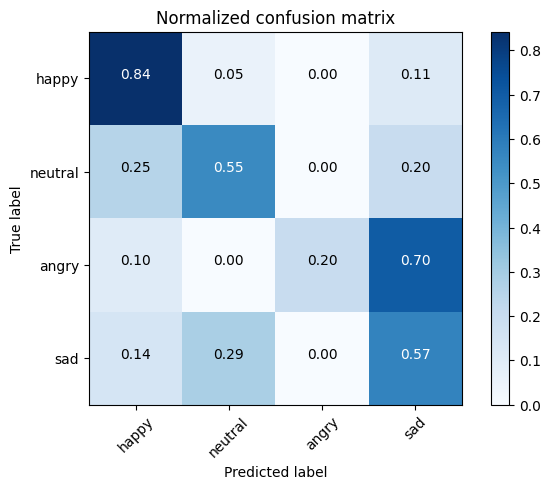

In [31]:
random_forest_params = {
    'n_estimators': 100,
    'criterion': 'gini',
    'max_depth': 6,
}
accuracy, precision, recall, f1, cm = RF_model(random_forest_params).values()
print(accuracy, precision, recall, f1)
plot_confusion_matrix(cm, classes=AVAILABLE_EMOTIONS, normalize=True, title='Normalized confusion matrix')

In [32]:
def SVM_classifier(model_params):
    X_train, X_test, y_train, y_test = load_data(test_size=0.25)
    model = SVC(**model_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return get_model_validations(y_test, y_pred)


accuracy:  0.2857142857142857 precision:  0.8305084745762712 recall:  0.2857142857142857 f1:  0.20197473759117596
Normalized confusion matrix
[[0.05263158 0.         0.         0.94736842]
 [0.         0.1        0.         0.9       ]
 [0.         0.         0.1        0.9       ]
 [0.         0.         0.         1.        ]]


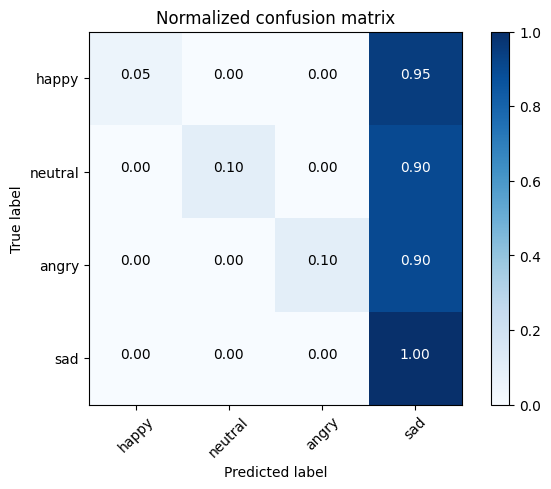

In [39]:
svm_model_params = {
    'C': 10,
}
accuracy, precision, recall, f1, cm = SVM_classifier(svm_model_params).values()
print("accuracy: ",accuracy, "precision: ", precision,"recall: ", recall, "f1: ", f1)
plot_confusion_matrix(cm, classes=AVAILABLE_EMOTIONS, normalize=True, title='Normalized confusion matrix')

In [41]:
def KNN_classifier(model_params):
    X_train, X_test, y_train, y_test = load_data(test_size=0.20)
    model = KNeighborsClassifier(**model_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return get_model_validations(y_test, y_pred)

accuracy:  0.5490196078431373 precision:  0.5436308789249966 recall:  0.5490196078431373 f1:  0.5338481338481339
Normalized confusion matrix
[[0.86666667 0.06666667 0.06666667 0.        ]
 [0.41176471 0.47058824 0.         0.11764706]
 [0.         0.125      0.375      0.5       ]
 [0.18181818 0.27272727 0.18181818 0.36363636]]


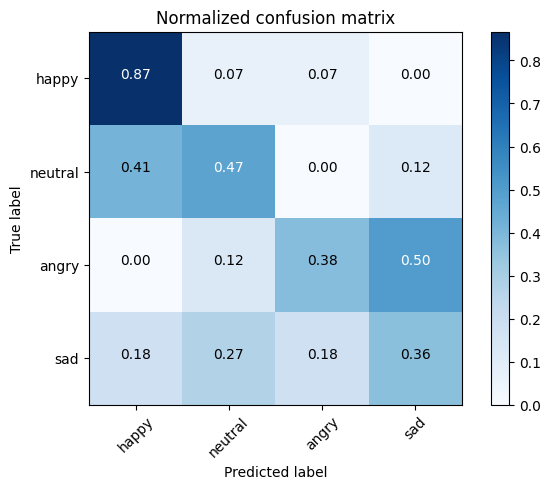

In [46]:
knn_model_params = {
    'n_neighbors': 8,
    'weights': 'uniform',
    'algorithm': 'auto',
    'leaf_size': 30,
}
accuracy, precision, recall, f1, cm = KNN_classifier(knn_model_params).values()
print("accuracy: ",accuracy, "precision: ", precision,"recall: ", recall, "f1: ", f1)
plot_confusion_matrix(cm, classes=AVAILABLE_EMOTIONS, normalize=True, title='Normalized confusion matrix')

In [50]:
def DT_classifier(model_params):
    X_train, X_test, y_train, y_test = load_data(test_size=0.20)
    model = DecisionTreeClassifier(**model_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return get_model_validations(y_test, y_pred)

accuracy:  0.5098039215686274 precision:  0.603641456582633 recall:  0.5098039215686274 f1:  0.4868202626496155
Normalized confusion matrix
[[0.53333333 0.2        0.         0.26666667]
 [0.35294118 0.47058824 0.         0.17647059]
 [0.         0.125      0.125      0.75      ]
 [0.         0.18181818 0.         0.81818182]]


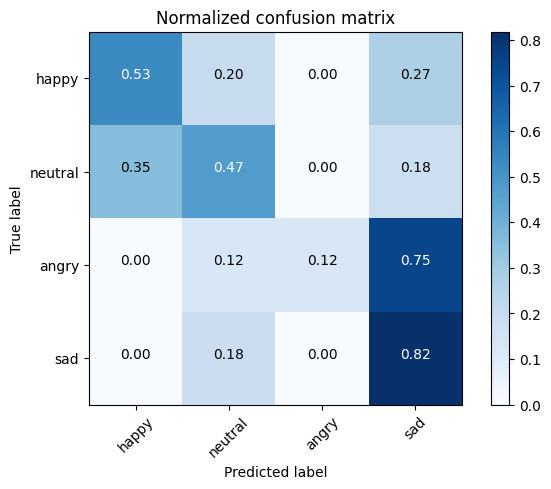

In [56]:
dt_model_params = {
    'criterion': 'gini',
    'splitter': 'best',
    'max_depth': 5,
}
accuracy, precision, recall, f1, cm = DT_classifier(dt_model_params).values()
print("accuracy: ",accuracy, "precision: ", precision,"recall: ", recall, "f1: ", f1)
plot_confusion_matrix(cm, classes=AVAILABLE_EMOTIONS, normalize=True, title='Normalized confusion matrix')

In [57]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D
from tensorflow.keras.utils import to_categorical


In [ ]:
#now lets make the model
model = Sequential()
model.add(Conv1D(filters=1, kernel_size=5, activation='relu', input_shape=(window_size, 2)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
#add our features to the last fully connected layer
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()

model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])